In [1]:
from classMVA import MVA
import numpy as np
import matplotlib.pyplot as plt


# 1. Sacamos la figura con la Toolbox

## 1.1. Importación de datos a RDD

In [2]:
import urllib2
from pyspark.mllib.regression import LabeledPoint

response = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn")
textdata = response.read()
RDD = sc.parallelize(textdata.split('\n')[:-1]).map(lambda line: line.split(" "))

RDD_labeled=RDD.map(lambda x: LabeledPoint(x[-1],x[0:-1]))

RDD_PCA = RDD_labeled.map(lambda x: x.features)


## 1.2. Extraemos 15 componentes

In [3]:
nprojections = 15

PCA_model = MVA('PCA','none','None',1e-5,nprojections,1e-8,1e-5,100,30)
PCA_model.fit(RDD_PCA)

(15, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 15
Extracting projection vector 1 out of 15
Extracting projection vector 2 out of 15
Extracting projection vector 3 out of 15
Extracting projection vector 4 out of 15
Extracting projection vector 5 out of 15
Extracting projection vector 6 out of 15
Extracting projection vector 7 out of 15
Extracting projection vector 8 out of 15
Extracting projection vector 9 out of 15
Extracting projection vector 10 out of 15
Extracting projection vector 11 out of 15
Extracting projection vector 12 out of 15
Extracting projection vector 13 out of 15
Extracting projection vector 14 out of 15
(15, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 15
Extracting projection vector 1 out of 15
Extracting projection vector 2 out of 15
Extracting projection vector 3 out of 15
Extracting projection vector 4 out of 15
Extracting projection vector 5 out of 15
Extracting projection vector 6 out of 15
Extracting projection vector 7 out of 1

## 1.3. Dibujamos los vectores de proyección

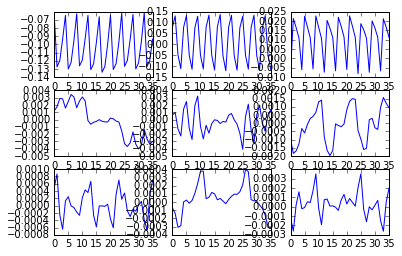

In [5]:
fig = plt.figure()

ax1 = fig.add_subplot(331)
ax1.plot(PCA_model._U[0,], 'b-')

ax1 = fig.add_subplot(332)
ax1.plot(PCA_model._U[1,], 'b-')

ax1 = fig.add_subplot(333)
ax1.plot(PCA_model._U[2,], 'b-')

ax1 = fig.add_subplot(334)
ax1.plot(PCA_model._U[3,], 'b-')

ax1 = fig.add_subplot(335)
ax1.plot(PCA_model._U[4,], 'b-')

ax1 = fig.add_subplot(336)
ax1.plot(PCA_model._U[5,], 'b-')

ax1 = fig.add_subplot(337)
ax1.plot(PCA_model._U[6,], 'b-')

ax1 = fig.add_subplot(338)
ax1.plot(PCA_model._U[7,], 'b-')

ax1 = fig.add_subplot(339)
ax1.plot(PCA_model._U[8,], 'b-')

plt.show()

## 1.4. Evolución de la función objetivo al incrementar el número de componentes

In [10]:
X_projected = np.array(PCA_model.predict(RDD_PCA).collect())
print X_projected.shape

X_pca = RDD_PCA.collect()
media = np.mean(X_pca, axis=0)
X_pca = X_pca-media

print X_pca.shape

(4435, 15)
(4435, 36)


In [11]:
from sklearn.linear_model import LinearRegression

mses = list()

n_targets = 36

for np2 in range(nprojections):
    mse = 0
    X_components = X_projected[:,:np2+1]
    for k in range(n_targets):
        targets = X_pca[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components, targets)
        predictions = lm.predict(X_components)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses.append(mse)

MSE para 1 proyecciones: 6430.87620532
MSE para 2 proyecciones: 1674.79261092
MSE para 3 proyecciones: 1261.28076846
MSE para 4 proyecciones: 970.929522452
MSE para 5 proyecciones: 725.097132354
MSE para 6 proyecciones: 523.865407291
MSE para 7 proyecciones: 387.465528125
MSE para 8 proyecciones: 325.026557129
MSE para 9 proyecciones: 277.679331269
MSE para 10 proyecciones: 237.308986552
MSE para 11 proyecciones: 208.428433892
MSE para 12 proyecciones: 187.391368461
MSE para 13 proyecciones: 167.426888984
MSE para 14 proyecciones: 149.335580765
MSE para 15 proyecciones: 134.642776999


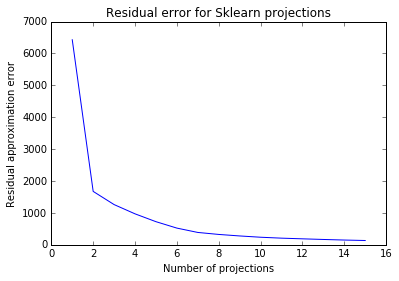

In [12]:
plt.plot(map(lambda x: x+1, range(nprojections)), mses)
plt.xlabel('Number of projections')
plt.ylabel('Residual approximation error')
plt.title('Residual error for Sklearn projections')
plt.show()

# 2. Para el cálculo distribuido de los MSE

In [ ]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

RDD_projected = prueba.predict(RDD_PCA)
mses = list()

n_targets = 36

for np in range(max_feat):
    nprojections = np+1
    mse = 0
    RDD_nprojections = RDD_projected.map(lambda x: x[:nprojections])
    for k in range(n_targets):
        RDD_target = RDD_PCA.map(lambda x: x[k])
        media = RDD_target.mean()
        RDD_target = RDD_target.map(lambda x: x - media)
        
        parsedData = RDD_target.zip(RDD_nprojections)
        
        parsedData = parsedData.map(lambda x: LabeledPoint(x[0], x[1:]))
        #print parsedData.first()
        #Entrenamos el modelo
        model = LinearRegressionWithSGD.train(parsedData, iterations=100, step=1e-5)
        # Evaluate the model on training data
        valuesAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features.T)))
        MSE_iter = valuesAndPreds.map(lambda (v, p): (v - p)**2).mean()
        mse += MSE_iter
    print 'MSE para ' + str(nprojections) + ' proyecciones: ' + str(mse)
    mses.append(mse)

MSE para 1 proyecciones: [ 10131.92148449]
MSE para 2 proyecciones: [ 8191.17565693]
MSE para 3 proyecciones: [ 8163.1439772]
MSE para 4 proyecciones: [ 8163.131337]
MSE para 5 proyecciones: [ 8163.11715168]
MSE para 6 proyecciones: [ 8163.11439298]
MSE para 7 proyecciones: [ 8163.11422989]


In [6]:
num_feat=[1,2,3,4,5,6,7,8,9,10]
mses=[]
for i in range(len(num_feat)) :
    prueba = MVA('PCA','l1','None',1e-5,i+1, 0.01,1e-5,100,30)
    print num_feat[i+1]
    prueba.fit(RDD_PCA)
    U=prueba._U
    W=prueba._W
    mse=RDD_PCA.map(lambda x: np.mean(np.array(x - np.dot(W,np.dot(x, U.T)))**2)).mean()
    num_feat.append(mse)
    print mse 
    print 'First iteration for feature' + str(i+1) 

2
(1, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 1
(1, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 1
Frobenius norm error: 0.000448099874717
(1, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 1
Frobenius norm error: 7.66262335659e-06
1201.82218655
First iteration for feature1
3
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
Frobenius norm error: 0.0163483091633
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
Frobenius norm error: 0.000107681869892
(2, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 2
Extracting projection vector 1 out of 2
Frobenius norm error: 1.7339870077e-06
1099.05553229
First iteration for feature2
4
(3, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 3
Extracting projection v

In [9]:
print num_feat

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1201.8221865491125, 1099.0555322896184, 1132.2652481206308, 1132.0606964640617, 1131.9461870983992, 1131.8777214129454, 1131.8603316602855, 1131.8569705010575, 1131.855010546891, 1131.8653408497933]


In [5]:
reg_param=[1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1,1]
Us_toolbox=[]
for i in range(len(reg_param)) :
    prueba = MVA('PCA','l1','None',1e-5,10, reg_param[i],1e-5,100,30)
    print reg_param[i]
    prueba.fit(RDD_PCA)
    Us_toolbox.append(prueba._U)
    print 'First iteration for ' + str(reg_param[i]) 


1e-08
(10, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 10
Extracting projection vector 1 out of 10
Extracting projection vector 2 out of 10
Extracting projection vector 3 out of 10
Extracting projection vector 4 out of 10
Extracting projection vector 5 out of 10
Extracting projection vector 6 out of 10
Extracting projection vector 7 out of 10
Extracting projection vector 8 out of 10
Extracting projection vector 9 out of 10
(10, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 10
Extracting projection vector 1 out of 10
Extracting projection vector 2 out of 10
Extracting projection vector 3 out of 10
Extracting projection vector 4 out of 10
Extracting projection vector 5 out of 10
Extracting projection vector 6 out of 10
Extracting projection vector 7 out of 10
Extracting projection vector 8 out of 10
Extracting projection vector 9 out of 10
Frobenius norm error: 0.0935118035042
(10, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 10
Extracting pro

In [4]:
reg_param=[1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1,1]
Us_toolbox=[]
for i in range(len(reg_param)) :
    prueba = MVA('OPLS','l1','norm',1e-5,10,reg_param[i],1e-3,100)
    print reg_param[i]
    prueba.fit(RDD_sat)
    Us_toolbox.append(prueba._U)
    print 'First iteration for ' + str(reg_param[i]) 

1e-08
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00365037211321
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 7.32919116913e-05
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 6

LinAlgError: SVD did not converge

In [6]:
print Us_toolbox[0]

[[ -6.30723181e-02  -1.27437872e-01  -1.19432348e-01  -9.33875803e-02
   -6.44685102e-02  -1.29956344e-01  -1.22041703e-01  -9.56360878e-02
   -6.26710317e-02  -1.26094900e-01  -1.19012114e-01  -9.30626582e-02
   -6.46471576e-02  -1.30697885e-01  -1.23725996e-01  -9.73267733e-02
   -6.62108125e-02  -1.33851476e-01  -1.26914257e-01  -9.97905772e-02
   -6.42927054e-02  -1.30567696e-01  -1.23436879e-01  -9.70233629e-02
   -6.16716250e-02  -1.26716385e-01  -1.19505298e-01  -9.37392954e-02
   -6.34843619e-02  -1.29852686e-01  -1.22261474e-01  -9.59725900e-02
   -6.15594561e-02  -1.26897494e-01  -1.18763349e-01  -9.32632865e-02]
 [  7.79858877e-02   1.30514037e-01  -4.79096004e-02  -1.10976591e-01
    7.86210303e-02   1.32058038e-01  -4.95129589e-02  -1.13646178e-01
    7.66869321e-02   1.28675237e-01  -5.03380425e-02  -1.12224192e-01
    7.90079823e-02   1.34151676e-01  -5.02094938e-02  -1.16630256e-01
    8.06723832e-02   1.36773746e-01  -5.30915780e-02  -1.20157144e-01
    7.88044050e-02 

In [12]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(RDD_PCA.collect())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
from numpy import linalg as lin
import math
array_error=[]
for i in range(len(reg_param)-1) :
    result=math.sqrt(lin.norm(pca.components_ - Us_toolbox[i],'fro'))
    array_error.append(result)

print array_error

[1.8931920358273555, 1.893192038427425, 1.8931920358055456, 1.8931920272562606, 1.8931906089771542, 1.8931776849840662]


In [ ]:
import matplotlib.pyplot as plt
plt.plot([1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1], [Us_toolbox[0],Us_toolbox[1],Us_toolbox[0],Us_toolbox[0],Us_toolbox[0],Us_toolbox[0]], 'ro')

In [7]:
prueba = MVA('OPLS','l1','norm',1e-5,10,1e-8,1e-3,100)
prueba.fit(RDD_labeled)

(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00368934510614
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00205095620702
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 2.221519

In [8]:
reg_param=[1e-8,1e-6,1e-5,1e-4, 1e-2, 1e-1,1]
Us_toolbox=[]
for i in range(len(reg_param)) :
    prueba = MVA('OPLS','l1','norm',1e-5,10,reg_param[i],1e-3,100)
    print reg_param[i]
    prueba.fit(RDD_labeled)
    Us_toolbox.append(prueba._U)
    print 'First iteration for ' + str(reg_param[i]) 

1e-08
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.00417402062326
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 0.000250911143384
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 1